<a href="https://colab.research.google.com/github/ShangWeiKuo/Portfolio/blob/main/Python/Classification/Multiclass/Wafer/Casting_binary_classification_BayesianOptimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras-hypetune
!pip install keras-tuner
!pip install tf_keras_vis

     |████████████████████████████████| 965 kB 35.3 MB/s 
  Attempting uninstall: hyperopt
    Found existing installation: hyperopt 0.1.2
    Uninstalling hyperopt-0.1.2:
      Successfully uninstalled hyperopt-0.1.2
     |████████████████████████████████| 98 kB 8.2 MB/s 
     |████████████████████████████████| 53 kB 2.6 MB/s 


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm, pyplot
import cv2
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.applications import imagenet_utils
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import auc, roc_curve, roc_auc_score, confusion_matrix, classification_report
import keras_tuner as kt
from kerastuner.tuners import BayesianOptimization
from tf_keras_vis.gradcam import Gradcam, GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from tqdm import tqdm

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


In [3]:
train_path = '/content/drive/MyDrive/Anomaly detection/casting_data/train'
test_path = '/content/drive/MyDrive/Anomaly detection/casting_data/test'

In [4]:
BATCH_SIZE = 32

In [5]:
train = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                             shear_range=0.2, 
                             zoom_range=0.2,
                             horizontal_flip=True, 
                             vertical_flip=True, 
                             validation_split=0.3)

test = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

training_set = train.flow_from_directory(train_path, 
                      target_size=(224, 224), 
                      class_mode = 'binary', 
                      classes=['ok_front', 'def_front'], 
                      shuffle=True, 
                      batch_size=BATCH_SIZE,
                      color_mode="grayscale",
                      subset='training')

val_set = train.flow_from_directory(train_path, 
                   target_size=(224, 224), 
                   class_mode = 'binary', 
                   classes=['ok_front', 'def_front'], 
                   shuffle=False, 
                   batch_size=BATCH_SIZE,
                   color_mode="grayscale",
                   subset='validation')

test_set = test.flow_from_directory(test_path, 
                   target_size=(224, 224), 
                   class_mode = 'binary', 
                   classes=['ok_front', 'def_front'], 
                   shuffle=False, 
                   batch_size=BATCH_SIZE,
                   color_mode="grayscale")

Found 4644 images belonging to 2 classes.
Found 1989 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


In [6]:
training_set.class_indices

{'def_front': 1, 'ok_front': 0}

In [7]:
test_set.class_indices

{'def_front': 1, 'ok_front': 0}

In [8]:
X_train, y_train = training_set.next()

In [9]:
train_def_idx = np.where(y_train == 1)
train_ok_idx = np.where(y_train == 0)

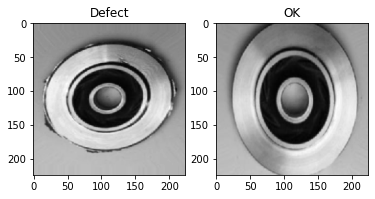

In [10]:
pic1 = plt.subplot(1, 2, 1)
pic1.imshow(X_train[train_def_idx][0].reshape((X_train.shape[1], X_train.shape[2])), cmap="gray")
pic1.set_title("Defect")
pic2 = plt.subplot(1, 2, 2)
pic2.imshow(X_train[train_ok_idx][0].reshape((X_train.shape[1], X_train.shape[2])), cmap="gray")
pic2.set_title("OK")
plt.show()

In [11]:
### batch-size = 32
### range的部分要除以batch否則後面的grad-cam會出現格式錯誤的訊息
### 取得test資料的圖片內容與標籤
test_set.reset()
X_test, y_test = next(test_set)
for i in tqdm(range((test_set.n//BATCH_SIZE)-1)): #1st batch is alread fetched before the for loop
  img, label = next(test_set)
  X_test = np.append(X_test, img, axis=0)
  y_test = np.append(y_test, label, axis=0)
print(X_test.shape, y_test.shape)

100%|██████████| 21/21 [01:54<00:00,  5.44s/it]

(704, 224, 224, 1) (704,)


In [12]:
test_def_idx = np.where(y_test == 1)
test_ok_idx = np.where(y_test == 0)

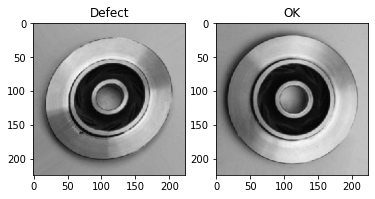

In [13]:
pic1 = plt.subplot(1, 2, 1)
pic1.imshow(X_test[test_def_idx][0].reshape((X_test.shape[1], X_test.shape[2])), cmap="gray")
pic1.set_title("Defect")
pic2 = plt.subplot(1, 2, 2)
pic2.imshow(X_test[test_ok_idx][0].reshape((X_test.shape[1], X_test.shape[2])), cmap="gray")
pic2.set_title("OK")
plt.show()

In [14]:
def create_model(hp):

  input_shape = (224,224,1)
  input = Input(input_shape, name='input')
  # Add a first layer
  layer = Conv2D(hp.Int('conv1', min_value=8, max_value=64, step=8), (3,3), activation='relu', padding='same')(input)
  layer = BatchNormalization()(layer)
  layer = MaxPooling2D(pool_size=(2,2), strides=2)(layer)

  # Add a second layer
  layer = Conv2D(hp.Int('conv2', min_value=8, max_value=64, step=8), (3,3), activation='relu', padding='same')(layer)
  layer = BatchNormalization()(layer)
  layer = MaxPooling2D(pool_size=(2,2), strides=2)(layer)

  # Add a third layer
  layer = Conv2D(hp.Int('conv3', min_value=8, max_value=64, step=8), (3,3), activation='relu', padding='same')(layer)
  layer = BatchNormalization()(layer)
  layer = MaxPooling2D(pool_size=(2,2), strides=2)(layer)

  # Flattening
  layer = Flatten(name='flatten')(layer)

  # Add a hidden layer
  layer = Dense(hp.Int('units', min_value=32, max_value=128, step=32), activation='relu')(layer)

  output = Dense(1, activation='sigmoid')(layer)

  model = Model(inputs=[input], outputs=[output])
  model.summary()
  model.compile(Adam(hp.Choice('learning_rate', values=[1e-4, 1e-3])), loss='binary_crossentropy', metrics=['binary_accuracy'])

  return model

In [15]:
es = EarlyStopping(monitor='val_loss', verbose=2, patience=10,  restore_best_weights=True)

In [16]:
hyper_model = create_model
bayes = kt.tuners.BayesianOptimization(hyper_model, objective='binary_accuracy', seed=2021, max_trials=3)
bayes.search(training_set, epochs=20, validation_data=val_set, batch_size=BATCH_SIZE, callbacks=[es])

Trial 3 Complete [00h 14m 47s]
binary_accuracy: 0.995047390460968

Best binary_accuracy So Far: 0.9952626824378967
Total elapsed time: 01h 07m 17s
INFO:tensorflow:Oracle triggered exit


In [17]:
# Get best hyperparameters
bestHP = bayes.get_best_hyperparameters(num_trials=1)[0]

In [18]:
# Call model and train the model
model = bayes.hypermodel.build(bestHP)
History = model.fit_generator(training_set, steps_per_epoch=training_set.n//BATCH_SIZE, validation_data=val_set, validation_steps=val_set.n//BATCH_SIZE, epochs=80, verbose=2, workers=8, callbacks=[es])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 56)      560       
                                                                 
 batch_normalization_3 (Batc  (None, 224, 224, 56)     224       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 56)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 40)      20200     
                                                                 
 batch_normalization_4 (Batc  (None, 112, 112, 40)     160 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/80
145/145 - 34s - loss: 0.3990 - binary_accuracy: 0.8237 - val_loss: 1.5000 - val_binary_accuracy: 0.5655 - 34s/epoch - 236ms/step
Epoch 2/80
145/145 - 33s - loss: 0.2172 - binary_accuracy: 0.9059 - val_loss: 1.7010 - val_binary_accuracy: 0.5655 - 33s/epoch - 228ms/step
Epoch 3/80
145/145 - 33s - loss: 0.1503 - binary_accuracy: 0.9378 - val_loss: 1.2865 - val_binary_accuracy: 0.5650 - 33s/epoch - 226ms/step
Epoch 4/80
145/145 - 33s - loss: 0.0968 - binary_accuracy: 0.9690 - val_loss: 0.5693 - val_binary_accuracy: 0.7031 - 33s/epoch - 227ms/step
Epoch 5/80
145/145 - 33s - loss: 0.0754 - binary_accuracy: 0.9742 - val_loss: 0.1334 - val_binary_accuracy: 0.9441 - 33s/epoch - 225ms/step
Epoch 6/80
145/145 - 33s - loss: 0.0914 - binary_accuracy: 0.9679 - val_loss: 3.1273 - val_binary_accuracy: 0.5403 - 33s/epoch - 228ms/step
Epoch 7/80
145/145 - 33s - loss: 0.0679 - binary_accuracy: 0.9785 - val_loss: 0.4319 - val_binary_accuracy: 0.8508 - 33s/epoch - 227ms/step
Epoch 8/80
145/145 -

In [19]:
# Save model
model.save("/content/drive/MyDrive/Anomaly detection/casting_nn_model.h5")

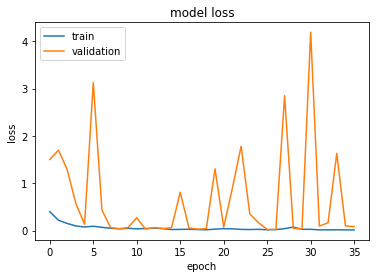

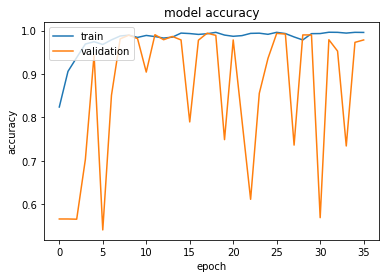

In [20]:
# Loss plot
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Accuracy plot 
plt.plot(History.history['binary_accuracy'])
plt.plot(History.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [21]:
# Evaluation 1 - Training data
scores_train = model.evaluate(training_set, steps=training_set.n//BATCH_SIZE)
print("Accuracy: ", round(scores_train[1], 3))

145/145 [==============================] - 29s 202ms/step - loss: 0.0123 - binary_accuracy: 0.9968
Accuracy:  0.997


In [22]:
# Evaluation 2 - Validataion data
scores_val = model.evaluate(val_set, steps=val_set.n//BATCH_SIZE)
print("Accuracy: ", round(scores_val[1], 3))

62/62 [==============================] - 12s 198ms/step - loss: 0.0165 - binary_accuracy: 0.9940
Accuracy:  0.994


In [23]:
# Evaluation 3 - Testing data
scores_test = model.evaluate(test_set, steps=test_set.n//BATCH_SIZE)
print("Accuracy: ", round(scores_test[1], 3))

22/22 [==============================] - 2s 105ms/step - loss: 0.0069 - binary_accuracy: 0.9986
Accuracy:  0.999


In [24]:
# Evaluation - Overview
eval_df = np.array(
            [
              [round(scores_train[1], 3), round(scores_val[1], 3), round(scores_test[1], 3)]
            ]
          )

eval_df = pd.DataFrame(eval_df, columns=['Train', 'Validation', 'Test'])
rowname = np.array(['Accuracy'])
eval_df.index = rowname
eval_df

,Train,Validation,Test
Accuracy,0.997,0.994,0.999


In [25]:
# Evaluation - Confusion Matrix Part 1
pred_probs = model.predict_generator(test_set, verbose=1)
predictions = pred_probs > 0.5
predictions = np.squeeze(predictions, axis=-1).astype("int32")
true = test_set.classes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


23/23 [==============================] - 3s 111ms/step


In [26]:
# Evaluation - Confusion Matrix Part 2
confusion_matrix(true, predictions)

array([[262,   0],
       [  1, 452]])

In [27]:
# Evaluation - Confusion Matrix Part 3
print(classification_report(true, predictions, digits=3))

              precision    recall  f1-score   support

           0      0.996     1.000     0.998       262
           1      1.000     0.998     0.999       453

    accuracy                          0.999       715
   macro avg      0.998     0.999     0.998       715
weighted avg      0.999     0.999     0.999       715



In [28]:
# Evaluation - AUC & ROC Part 1
test_auc = roc_auc_score(true, pred_probs)
true_probs = [0 for _ in range(len(true))]

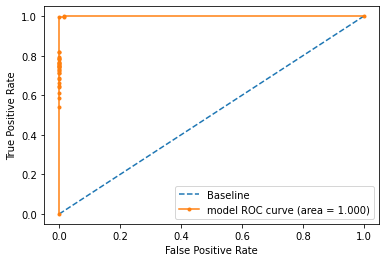

In [29]:
# Evaluation - AUC & ROC Part 2

# calculate roc curves
true_fpr, true_tpr, _ = roc_curve(true, true_probs)
pred_fpr, pred_tpr, _ = roc_curve(true, pred_probs)

# plot the roc curve for the model
pyplot.plot(true_fpr, true_tpr, linestyle='--', label='Baseline')
pyplot.plot(pred_fpr, pred_tpr, marker='.', label='model ROC curve (area = %0.3f)' % test_auc)
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend(loc="lower right")
# show the plot
pyplot.show()

In [30]:
def Grad_CAM_savepictures(file_index, model):

  def loss(output):
    L = y_train[file_index].astype(np.uint8)
    return (output[0][L-1])
    
  # def model_modifier(m):
  #   m.layers[-1].activation = tf.keras.activations.linear
  #   return m
  replace2linear = ReplaceToLinear()

  # Create Gradcam object
  gradcam = Gradcam(model, model_modifier=replace2linear, clone=True)
  originalimage = X_train[file_index][:,:,:]
  originalimage = originalimage.reshape((1, originalimage.shape[0], originalimage.shape[1], 1))

  # Generate heatmap with GradCAM
  cam = gradcam(loss, originalimage, penultimate_layer=-1)
  cam = normalize(cam)

  #overlap image
  ax1 = plt.subplot(1, 2, 1)
  heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)
  ax1.imshow(X_train[file_index].reshape((X_train.shape[1], X_train.shape[2])),cmap="gray")
  ax1.imshow(heatmap.reshape((X_train.shape[1], X_train.shape[2], 3)), cmap='jet', alpha=0.4) # overlay
  ax1.set_title("Grad-CAM")

  gradcam = GradcamPlusPlus(model, model_modifier=replace2linear, clone=True)
  cam = gradcam(loss, originalimage, penultimate_layer=-1)
  cam = normalize(cam)

  ax1 = plt.subplot(1, 2, 2)
  heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)
  ax1.imshow(X_train[file_index].reshape((X_train.shape[1],X_train.shape[2])), cmap="gray")
  ax1.imshow(heatmap.reshape((X_train.shape[1], X_train.shape[2], 3)), cmap='jet', alpha=0.4) # overlay
  ax1.set_title("Grad-CAM++")

  plt.show()

In [31]:
train_def_pic = train_def_idx[0][0]
train_ok_pic = train_ok_idx[0][0]

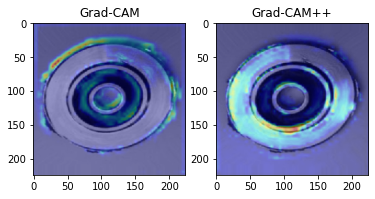

In [32]:
# Defect Grad-CAM & Grad-CAM++
Grad_CAM_savepictures(train_def_pic, model)

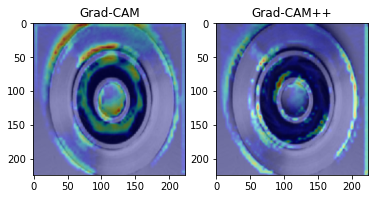

In [33]:
# OK Grad-CAM & Grad-CAM++
Grad_CAM_savepictures(train_ok_pic, model)